# Dot Plot of Neuromodulator Receptor Expression in the Lateral Habenula (MERFISH)

This notebook uses **MERFISH spatial transcriptomics** data from the Allen Brain Cell
(ABC) Atlas to visualize neuromodulator receptor expression across cell types in the
**lateral habenula (LHb)** of the mouse brain.

### Why the Lateral Habenula?
The LHb is a key node in reward/aversion circuitry and is strongly implicated in
depression, learned helplessness, and the antidepressant effects of ketamine. It
receives monoaminergic input and expresses diverse receptor subtypes. Understanding
which cell types express which receptors is critical for predicting drug effects.

### MERFISH Gene Panel Limitation
11 of 28 receptor genes are available in the MERFISH 550-gene panel:
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata with CCF Parcellation

In [3]:
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f"Total MERFISH cells with CCF: {len(ccf_meta):,}")

Total MERFISH cells with CCF: 3,739,961


## 3. Identify Lateral Habenula Cells

Filter to cells within the **lateral habenula (LH)** using CCF parcellation.
The LH is part of the epithalamus within the TH division.

In [4]:
# Filter to LH (lateral habenula)
lh_cells = ccf_meta[ccf_meta['parcellation_structure'] == 'LH'].copy()
print(f"Lateral habenula cells: {len(lh_cells):,}")

# Check substructures
print(f"\nSubstructures:")
for sub, count in lh_cells.groupby('parcellation_substructure', observed=True).size().sort_values(ascending=False).items():
    print(f"  {sub}: {count:,} cells")

print(f"\nAll subclasses:")
for sc_name, count in lh_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    print(f"  {sc_name}: {count:,} cells")

Lateral habenula cells: 2,599

Substructures:
  LH: 2,599 cells

All subclasses:
  146 LH Pou4f1 Sox1 Glut: 851 cells
  327 Oligo NN: 503 cells
  318 Astro-NT NN: 469 cells
  333 Endo NN: 223 cells
  167 PRC-PAG Tcf7l2 Irx2 Glut: 114 cells
  326 OPC NN: 73 cells
  321 Astroependymal NN: 59 cells
  332 SMC NN: 46 cells
  331 Peri NN: 39 cells
  330 VLMC NN: 31 cells
  168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut: 29 cells
  155 PRC-PAG Pax6 Glut: 27 cells
  151 TH Prkcd Grin2c Glut: 22 cells
  334 Microglia NN: 19 cells
  154 PF Fzd5 Glut: 15 cells
  145 MH Tac2 Glut: 12 cells
  202 PRT Tcf7l2 Gaba: 11 cells
  150 CM-IAD-CL-PCN Sema5b Glut: 10 cells
  169 PAG-SC Pou4f1 Zic1 Glut: 7 cells
  149 PVT-PT Ntrk1 Glut: 6 cells
  166 MRN Pou3f1 C1ql4 Glut: 5 cells
  152 RE-Xi Nox4 Glut: 3 cells
  319 Astro-TE NN: 3 cells
  222 PB Evx2 Glut: 2 cells
  173 PAG Pou4f2 Glut: 2 cells
  126 ARH-PVp Tbx3 Glut: 2 cells
  101 ZI Pax6 Gaba: 2 cells
  093 RT-ZI Gnb3 Gaba: 2 cells
  138 PH Pitx2 Glut: 2 cells
  

In [5]:
# Select subclasses with sufficient cells (>=20 given smaller structure)
subclass_counts = lh_cells.groupby('subclass', observed=True).size()
selected_subclasses = subclass_counts[subclass_counts >= 20].index.tolist()

lh_selected = lh_cells[lh_cells['subclass'].isin(selected_subclasses)].copy()

print(f"Selected: {len(selected_subclasses)} subclasses, {len(lh_selected):,} cells")
for sc_name, count in lh_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    sc_cells = lh_selected[lh_selected['subclass'] == sc_name]
    nt_vals = sc_cells['neurotransmitter'].value_counts()
    nt = nt_vals.index[0] if len(nt_vals) > 0 else '?'
    print(f"  {sc_name}: {count:,} cells  [{nt}]")

Selected: 13 subclasses, 2,486 cells
  146 LH Pou4f1 Sox1 Glut: 851 cells  [Glut]
  327 Oligo NN: 503 cells  [?]
  318 Astro-NT NN: 469 cells  [?]
  333 Endo NN: 223 cells  [?]
  167 PRC-PAG Tcf7l2 Irx2 Glut: 114 cells  [Glut]
  326 OPC NN: 73 cells  [?]
  321 Astroependymal NN: 59 cells  [?]
  332 SMC NN: 46 cells  [?]
  331 Peri NN: 39 cells  [?]
  330 VLMC NN: 31 cells  [?]
  168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut: 29 cells  [Glut]
  155 PRC-PAG Pax6 Glut: 27 cells  [Glut]
  151 TH Prkcd Grin2c Glut: 22 cells  [Glut]


## 4. Define Receptor Gene Lists

In [6]:
gene = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)

serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"Receptor genes in MERFISH panel: {len(receptor_genes)}/11")

Receptor genes in MERFISH panel: 11/11


## 5. Load Expression Data

In [7]:
csv_expr = 'lhb_merfish_expression.csv'
csv_meta = 'lhb_merfish_metadata.csv'

if os.path.exists(csv_expr):
    expression_data = pd.read_csv(csv_expr, index_col=0)
    print(f"Loaded from {csv_expr}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
else:
    file_path = abc_cache.get_file_path(
        directory='MERFISH-C57BL6J-638850',
        file_name='C57BL6J-638850/log2'
    )
    print(f"Loading MERFISH expression from: {file_path}")
    print(f"File size: {os.path.getsize(file_path) / 1e9:.1f} GB")

    adata = anndata.read_h5ad(file_path, backed='r')
    print(f"Expression matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes")

    gene_mask = adata.var.index.isin(gene_ensembl_ids)
    cell_mask = adata.obs.index.isin(lh_selected.index)

    cell_idx = np.where(cell_mask)[0]
    gene_idx = np.where(gene_mask)[0]

    print(f"LHb cells found: {len(cell_idx):,}")
    print(f"Receptor genes found: {len(gene_idx)}")

    subset = adata[cell_idx, gene_idx].to_memory()
    gene_filtered = adata.var[gene_mask]

    expression_data = subset.to_df()
    expression_data.columns = gene_filtered['gene_symbol'].values
    expression_data = expression_data[receptor_genes]

    adata.file.close()
    del adata

    expression_data.to_csv(csv_expr)
    print(f"Saved to {csv_expr}")

lh_selected.loc[expression_data.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter',
     'parcellation_structure', 'parcellation_substructure']
].to_csv(csv_meta)

print(f"\nExtracted: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

Loading MERFISH expression from: /home/user/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad
File size: 7.6 GB


Expression matrix: 4,334,174 cells x 550 genes
LHb cells found: 2,486
Receptor genes found: 11


Saved to lhb_merfish_expression.csv

Extracted: 2,486 cells x 11 genes


## 6. Build AnnData Object

In [8]:
adata_lh = anndata.AnnData(
    X=expression_data.values,
    obs=lh_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter',
          'parcellation_structure', 'parcellation_substructure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_lh.obs['subclass_short'] = adata_lh.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_lh.obs['supertype_short'] = adata_lh.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_lh.obs['subclass'] = pd.Categorical(adata_lh.obs['subclass'])
adata_lh.obs['supertype'] = pd.Categorical(adata_lh.obs['supertype'])
adata_lh.obs['subclass_short'] = pd.Categorical(adata_lh.obs['subclass_short'])
adata_lh.obs['supertype_short'] = pd.Categorical(adata_lh.obs['supertype_short'])

n_subclasses = adata_lh.obs['subclass_short'].cat.categories.size
n_supertypes = adata_lh.obs['supertype_short'].cat.categories.size
print(adata_lh)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 2486 × 11
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'parcellation_structure', 'parcellation_substructure', 'subclass_short', 'supertype_short'

13 subclasses, 34 supertypes


## 7. Dot Plot: LHb Cell Types (Subclass)

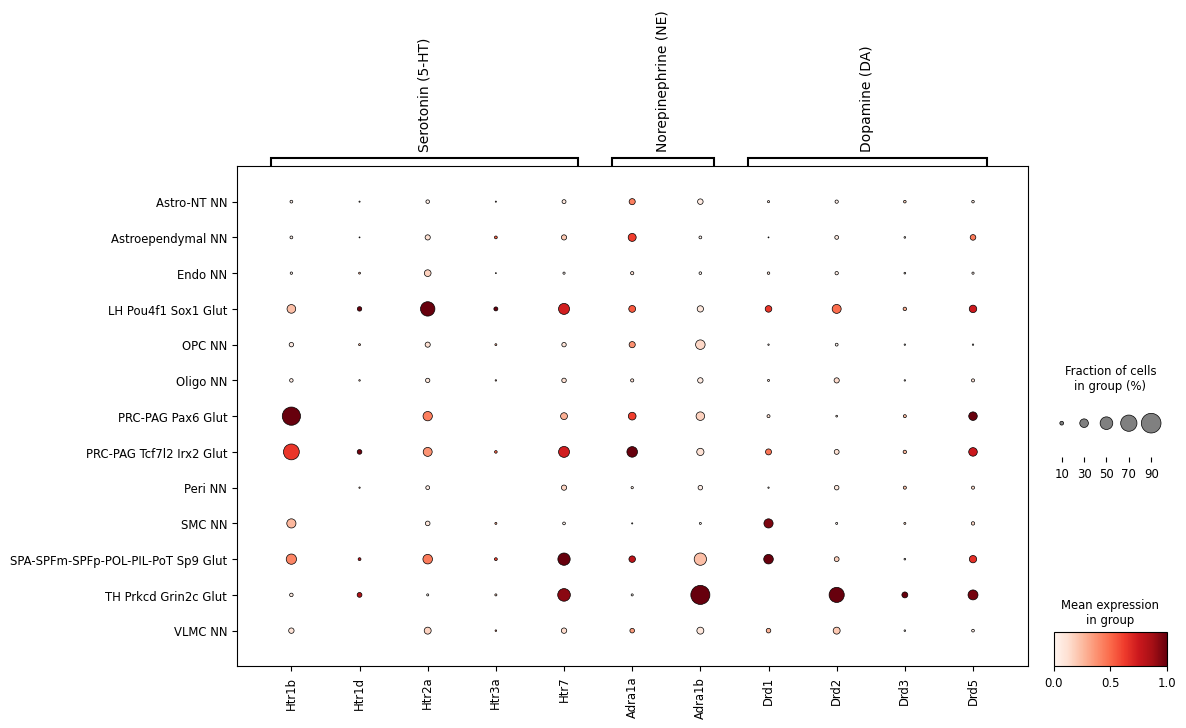

Saved: dotplot_LHb_MERFISH_receptors_by_subclass.png


In [9]:
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

dp = sc.pl.dotplot(
    adata_lh,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_LHb_MERFISH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_LHb_MERFISH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertypes with >= 20 cells: 16


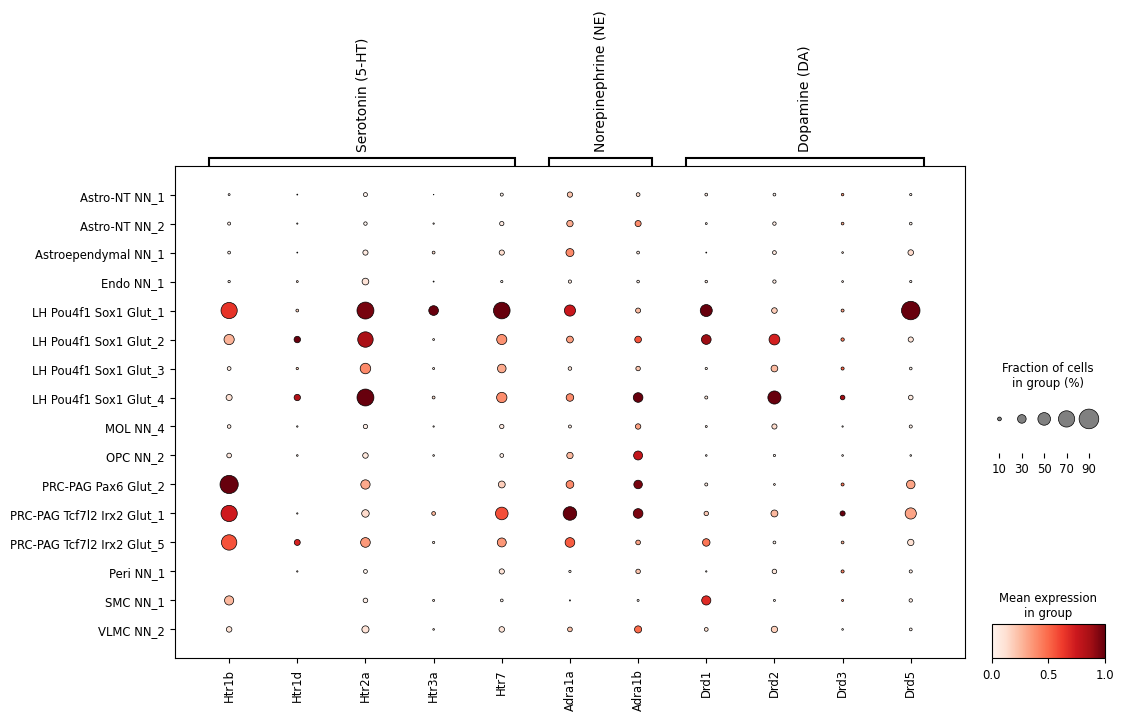

Saved: dotplot_LHb_MERFISH_receptors_by_supertype.png


In [10]:
min_cells = 20
supertype_counts = adata_lh.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_lh[adata_lh.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_st * 0.4)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_LHb_MERFISH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_LHb_MERFISH_receptors_by_supertype.png")

## 9. Summary Statistics

In [11]:
expr_df = pd.DataFrame(
    adata_lh.X,
    index=adata_lh.obs.index,
    columns=adata_lh.var.index
)
expr_df['subclass'] = adata_lh.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 70)
print("Mean Expression (log2) by LHb Subclass — MERFISH")
print("=" * 70)
display(mean_expr.round(2))

print("\n" + "=" * 70)
print("Fraction of Expressing Cells by LHb Subclass — MERFISH")
print("=" * 70)
display(frac_expr.round(3))

Mean Expression (log2) by LHb Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-NT NN,0.06,0.02,0.09,0.02,0.10,0.19,0.15,0.04,0.08,0.06,0.06
Astroependymal NN,0.05,0.02,0.16,0.06,0.17,0.27,0.07,0.01,0.11,0.03,0.24
Endo NN,0.05,0.03,0.20,0.02,0.05,0.07,0.06,0.06,0.09,0.03,0.04
LH Pou4f1 Sox1 Glut,0.41,0.13,0.89,0.12,0.49,0.24,0.20,0.29,0.49,0.08,0.38
OPC NN,0.11,0.03,0.16,0.03,0.11,0.17,0.33,0.02,0.05,0.02,0.02
Oligo NN,0.09,0.03,0.13,0.03,0.12,0.07,0.16,0.05,0.17,0.02,0.08
PRC-PAG Pax6 Glut,1.71,0.00,0.42,0.00,0.22,0.27,0.37,0.06,0.12,0.07,0.51
PRC-PAG Tcf7l2 Irx2 Glut,1.10,0.13,0.37,0.06,0.49,0.42,0.26,0.21,0.15,0.08,0.38
Peri NN,0.00,0.03,0.10,0.00,0.14,0.04,0.12,0.03,0.12,0.07,0.09



Fraction of Expressing Cells by LHb Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-NT NN,0.066,0.021,0.094,0.021,0.107,0.190,0.166,0.047,0.083,0.062,0.060
Astroependymal NN,0.068,0.017,0.153,0.068,0.153,0.271,0.068,0.017,0.102,0.034,0.169
Endo NN,0.054,0.040,0.215,0.018,0.049,0.081,0.063,0.058,0.085,0.036,0.049
LH Pou4f1 Sox1 Glut,0.302,0.123,0.595,0.107,0.416,0.221,0.197,0.210,0.317,0.089,0.248
OPC NN,0.123,0.041,0.151,0.041,0.123,0.192,0.342,0.027,0.068,0.027,0.027
Oligo NN,0.091,0.030,0.119,0.028,0.127,0.080,0.161,0.044,0.153,0.028,0.078
PRC-PAG Pax6 Glut,0.815,0.000,0.333,0.000,0.222,0.259,0.296,0.074,0.037,0.074,0.296
PRC-PAG Tcf7l2 Irx2 Glut,0.675,0.132,0.316,0.061,0.412,0.395,0.237,0.184,0.140,0.088,0.298
Peri NN,0.000,0.026,0.103,0.000,0.154,0.051,0.128,0.026,0.128,0.077,0.077
